In [1]:
from astropy.io import fits
from scipy import *
import numpy as np
from pylab import *
from astropy.coordinates import SkyCoord
import astropy.units as units
from IPython.display import Image
from astropy.coordinates import FK5, ICRS
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates import match_coordinates_sky
import WLanalysis
from scipy.interpolate import interp2d,NearestNDInterpolator

In [2]:
################ APOGESS DR14
## Number of objects: 277,371
hdulist = fits.open('allStar-l31c.2.fits')
ra_apo, dec_apo = hdulist[1].data['RA'], hdulist[1].data['DEC']

In [3]:
################ GAIA DR2 matched to APOGEE DR14
## Number of objects: 284,395
## description: https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html
## data_gaia = loadtxt('gaia_dr2_apogee_cross.dat')
## save('gaia_dr2_apogee_cross.npy', data_gaia)

data_gaia = load('gaia_dr2_apogee_cross.npy').T
cols_gaia = ['ra', 'ra_err', 'dec', 'dec_err', 'para', 'para_err', 'pmra', 'pmra_err', 
             'pmdec', 'pmdec_err', 'ra_dec_corr', 'ra_para_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 
             'dec_para_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'para_pmra_corr', 'para_pmdec_corr', 
             'pmra_pmdec_corr', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 
             'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'radial_velocity', 
             'radial_velocity_error', 'j', 'j_err', 'h', 'h_err', 'k', 'k_err', 'teff', 'teff_err', 'vmacro']
gaia = lambda field: data_gaia[cols_gaia.index(field)]

ra_gaia, dec_gaia = gaia('ra'), gaia('dec')
d_gaia = 1.0/gaia('para') ## distance in kpc
idx_good_para = (gaia('para_err')/gaia('para')<0.2)
def ap2abs (mags, Av=0):
    out = mags - 5.0*log10(d_gaia*1e2)-Av
    out[isnan(out)]=-9999.0
    return out

Babs, Rabs, Gabs, Jabs, Habs, Kabs = [ap2abs (gaia(iband)) for iband in 
            ['phot_bp_mean_mag', 'phot_rp_mean_mag', 'phot_g_mean_mag', 'j','h','k']]

AEN = gaia('astrometric_excess_noise')
AEN_min = sort(AEN)[int(len(AEN)*0.95)]

/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in less
/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in log10


In [4]:
## Payne
## payne_data = loadtxt('Apogee_The_Payne_relaxed.txt', usecols=range(1,24)).T
## APOGEE_ID RA[deg] Dec[deg] Teff[K] Logg vmic[km/s] CH NH OH MgH AlH 
## SiH SH KH CaH TiH CrH MnH FeH NiH CuH C12C13 22:vmac[km/s] 23:chi2_R 24:quality_flag
ra_payne, dec_payne, Teff_payne, logg_payne, vmic_payne, vmac_payne = loadtxt('Apogee_The_Payne_relaxed.txt', usecols=[1,2,3,4,5,22]).T
payne_apoid, payne_fit = loadtxt('Apogee_The_Payne_relaxed.txt', 
                                 usecols=(0,24), dtype='string').T

In [5]:
### At GAIA DR2 this reference epoch is always J2015.5 
### https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html

coord_gaia = SkyCoord(ra_gaia*u.degree, dec_gaia*u.degree, equinox='J2015.5', frame='icrs')
coord_payne = SkyCoord(ra_payne*u.degree, dec_payne*u.degree, equinox='J2000', frame='icrs')
coord_apo = SkyCoord(ra_apo*u.degree, dec_apo*u.degree, equinox='J2000', frame='icrs')
print 'set up coords'

idx_apo, d2_apo, d3_apo = coord_gaia.match_to_catalog_sky(coord_apo)
print 'done matching to apogee'
idx_payne, d2_payne, d3_payne = coord_gaia.match_to_catalog_sky(coord_payne)
idx_badpayne = ( array(d2_payne.value)>2.0/3600)
print 'done matching to payne'

set up coords
done matching to apogee
done matching to payne


In [6]:
Japo, Hapo, Kapo = [hdulist[1].data[iband] for iband in('J','H','K')]
Jabs_apo, Habs_apo, Kabs_apo = [ap2abs(Xcorr_apo[idx_apo]) for Xcorr_apo in (Japo, Hapo, Kapo)]

/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in log10


In [7]:
print 'GAIA data shape:',data_gaia.T.shape
print 'GAIA catalogue fieds:',len(cols_gaia)
print 'GAIA objects with no parallex:',sum(isnan(gaia('para')))

matchedpayne = intersect1d(payne_apoid, hdulist[1].data['APOGEE_ID'], assume_unique=0)
matchedpaynegaia = intersect1d(payne_apoid, hdulist[1].data['APOGEE_ID'][idx_apo], assume_unique=0)

######################
print 'Num of unique/total Payne objects:',len(unique(payne_apoid)),len(payne_apoid)
print 'Num of unique/total APOGEE objects:',len(unique(hdulist[1].data['APOGEE_ID'])),len(hdulist[1].data['APOGEE_ID'])
print 'Num of GAIA objects:',len(ra_gaia)
print 'Num of Payne-APOGEE matched unique objects:',len(matchedpayne)
print 'Num of unique APOGEE-GAIA match:',len(unique(idx_apo))
print 'Num of unique Payne-GAIA match:',len(unique(matchedpaynegaia) )
print 'Num of GAIA objects with multiples (to APO):',len(ra_gaia)-len(unique(idx_apo))

GAIA data shape: (284394, 36)
GAIA catalogue fieds: 36
GAIA objects with no parallex: 9573
Num of unique/total Payne objects: 251450 270346
Num of unique/total APOGEE objects: 258475 277371
Num of GAIA objects: 284394
Num of Payne-APOGEE matched unique objects: 251449
Num of unique APOGEE-GAIA match: 252338
Num of unique Payne-GAIA match: 245471
Num of GAIA objects with multiples (to APO): 32056


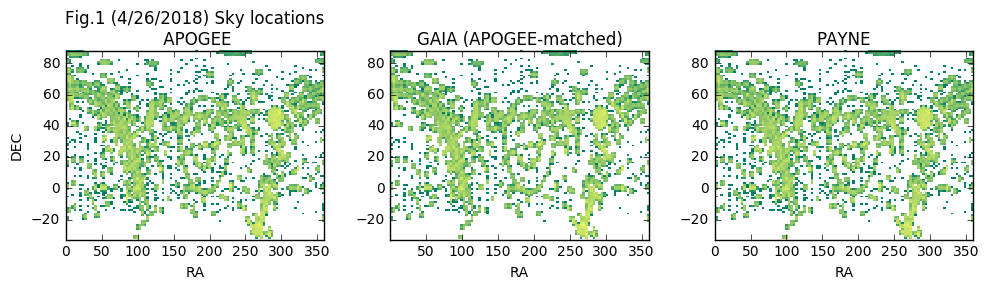

In [8]:
f, (ax1,ax2,ax3)=subplots(1,3,figsize=(10,3))
ax1.hist2d(ra_apo, dec_apo, bins=100,norm=mpl.colors.LogNorm(),cmap=mpl.cm.summer)
ax2.hist2d(ra_gaia, dec_gaia, bins=100,norm=mpl.colors.LogNorm(),cmap=mpl.cm.summer)
ax3.hist2d(ra_payne, dec_payne, bins=100,norm=mpl.colors.LogNorm(),cmap=mpl.cm.summer)

ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')
ax2.set_xlabel('RA')
ax3.set_xlabel('RA')
ax1.set_title('Fig.1 (4/26/2018) Sky locations\n APOGEE')
ax2.set_title('GAIA (APOGEE-matched)')
ax3.set_title('PAYNE')
plt.tight_layout()
show()

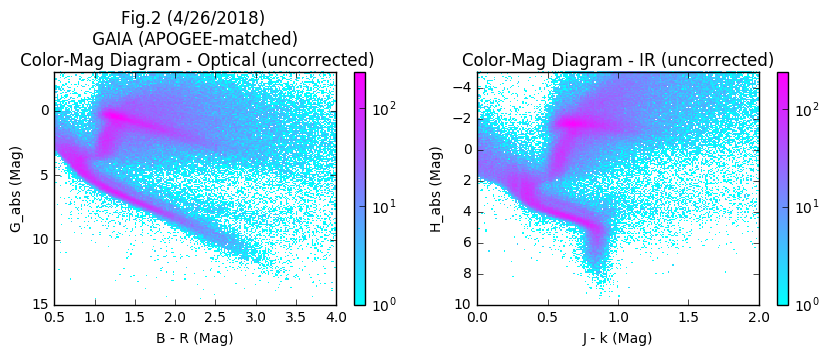

In [9]:
f, (ax1,ax2)=subplots(1,2,figsize=(10,3))
cs1=ax1.hist2d(Babs-Rabs, Gabs, bins=200, range = ((0.5,4),(-3, 15)),
          norm=mpl.colors.LogNorm(), cmap=mpl.cm.cool)
ax1.set_xlabel('B - R (Mag)')
ax1.set_ylabel('G_abs (Mag)')
ax1.invert_yaxis()
ax1.set_title('Fig.2 (4/26/2018) \n GAIA (APOGEE-matched) \n Color-Mag Diagram - Optical (uncorrected)')
f.colorbar(cs1[3], ax=ax1)

cs2=ax2.hist2d(Jabs-Kabs, Habs,  bins=200, range = ((0, 2),(-5, 10)),
          norm=mpl.colors.LogNorm(), cmap=mpl.cm.cool)
ax2.set_xlabel('J - k (Mag)')
ax2.set_ylabel('H_abs (Mag)')
ax2.invert_yaxis()
f.colorbar(cs2[3], ax=ax2)
ax2.set_title('Color-Mag Diagram - IR (uncorrected)')
show()

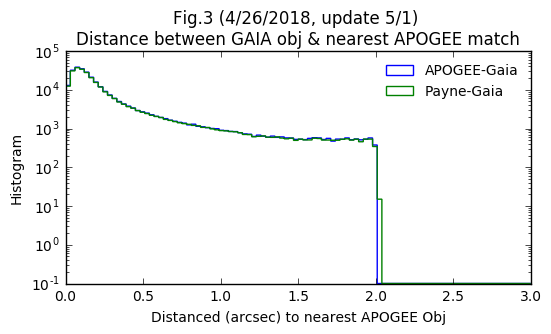

In [10]:
f, ax = subplots(1,1,figsize=(6,3))
ax.hist(d2_apo*3600, bins=100, range = (0,3), log=1,histtype='step',label='APOGEE-Gaia')
ax.hist(d2_payne*3600, bins=100, range = (0,3), log=1,histtype='step',label='Payne-Gaia')
ax.set_title('Fig.3 (4/26/2018, update 5/1) \nDistance between GAIA obj & nearest APOGEE match')
ax.set_xlabel('Distanced (arcsec) to nearest APOGEE Obj')
ax.set_ylabel('Histogram')
ax.legend(fontsize=10, frameon=0,loc=0)
show()

In [11]:
############ look at RV_FWHM, MAG_ABS plane, after removing tellurics
cut_telluric1 =logical_not (hdulist[1].data['APOGEE_TARGET2'][idx_apo] & 2**9)
cut_telluric2 =logical_not (hdulist[1].data['APOGEE2_TARGET2'][idx_apo] & 2**9)
cut_telluric = cut_telluric1&cut_telluric2
cut_logg     =(hdulist[1].data['LOGG'][idx_apo]<3.8) & (hdulist[1].data['LOGG'][idx_apo]>-10)
cut_teff     =(hdulist[1].data['TEFF'][idx_apo]<5000) 
classes = hdulist[1].data['ASPCAP_CLASS'][idx_apo]
cut_class    =(classes=='GKg_a')+(classes=='GKg_b')+(classes=='GKg_c')+(classes=='GKg_d')

In [12]:
RV = hdulist[1].data['RV_CCFWHM'][idx_apo]
VmacP = vmac_payne[idx_payne]
VmacA = hdulist[1].data['VMACRO'][idx_apo]

In [13]:
########## use 3d dust map to correct for extinction/redenning
run_dust_correction = 1

if run_dust_correction:
    from dustmaps.bayestar import BayestarQuery 
    from dustmaps.sfd import SFDQuery
    #from dustmaps.planck import PlanckQuery
    ## fetch maps: 4.3G
    ## dustmaps.bayestar.fetch()
    sfd = SFDQuery()
    bayestar = BayestarQuery(version='bayestar2017')
    coords3d = SkyCoord(ra_gaia*units.deg, dec_gaia*units.deg,distance=d_gaia*units.kpc, frame='icrs',equinox='J2015.5')
    ebv1 = sfd(coords3d)
    ebv2 = bayestar(coords3d, mode='median')

/Users/jia/anaconda/lib/python2.7/site-packages/astropy/coordinates/angles.py:656: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/jia/anaconda/lib/python2.7/site-packages/astropy/coordinates/angles.py:547: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/jia/anaconda/lib/python2.7/site-packages/astropy/coordinates/angles.py:547: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/jia/anaconda/lib/python2.7/site-packages/astropy/coordinates/angles.py:656: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/jia/anaconda/lib/python2.7/site-packages/dustmaps/sfd.py:88: RuntimeWarning: invalid value encountered in greater_equal
  m = (coords.b.deg >= 0) if pole =

In [14]:
### correct color
##  http://argonaut.skymaps.info/usage
## Table6 of SF2011: Ab/E(B−V)_SFD, Rv=3.1, B,G,R =2.976,1.850,1.452
## J,H,K =0.650, 0.327, 0.161
## Ab=ebv*[2.755,1.948,1.549]
Bcorr, Gcorr, Rcorr, Jcorr, Hcorr, Kcorr, Jcorr_apo, Hcorr_apo, Kcorr_apo =  \
     array([Babs, Gabs, Rabs, Jabs, Habs, Kabs, Jabs_apo, Habs_apo, Kabs_apo]) \
     -(ebv2.reshape(1,-1)*array([2.755,1.948,1.549,0.650, 0.327, 0.161,0.650, 0.327, 0.161]).reshape(-1,1))

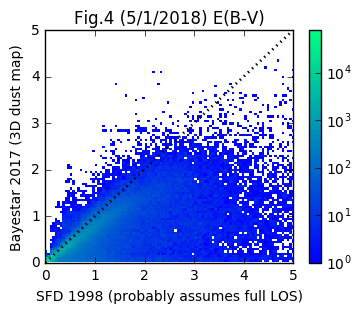

In [15]:
ebv1[isnan(ebv1)]=-99
ebv2[isnan(ebv2)]=-99

f, ax = subplots(1,1,figsize=(4,3))
cs=ax.hist2d(ebv1,ebv2,bins=100,range=((0,5),(0,5)),
             norm=mpl.colors.LogNorm(),cmap=mpl.cm.winter)
f.colorbar(cs[3], ax=ax)
ax.plot([0,5],[0,5],'k:', lw=2)
ax.set_xlabel('SFD 1998 (probably assumes full LOS)')
ax.set_ylabel('Bayestar 2017 (3D dust map)')
ax.set_title('Fig.4 (5/1/2018) E(B-V)')
show()

/Users/jia/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


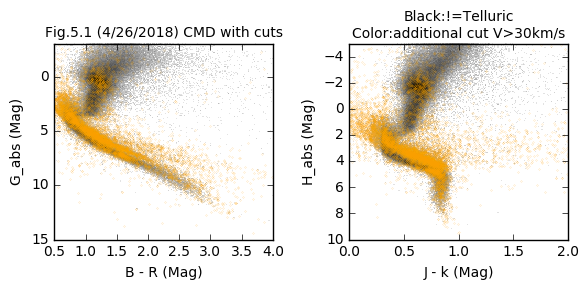

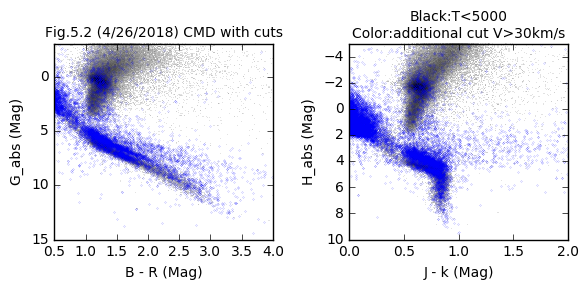

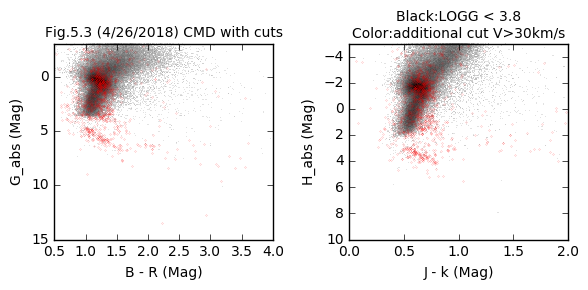

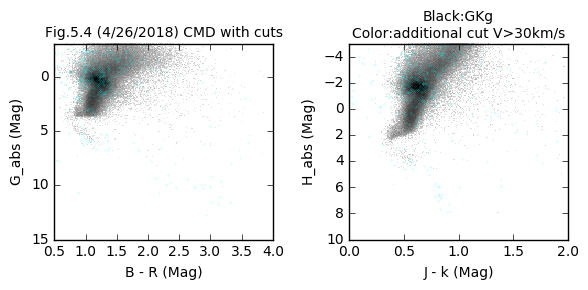

In [16]:
colors = ['orange','blue','red','cyan']
labels = ['!=Telluric', 'T<5000', 'LOGG < 3.8','GKg']
i=0
seed(5)
for icut in [cut_telluric, cut_teff, cut_logg, cut_class]:

    f, (ax1,ax2)=subplots(1,2,figsize=(6,3))
    ax1.hist2d( (Bcorr-Rcorr)[icut], Gcorr[icut], bins=200, range = ((0.5,4),(-3, 15)),
              norm=mpl.colors.LogNorm(), cmap=mpl.cm.binary)
    ax2.hist2d((Jcorr-Kcorr)[icut], Hcorr[icut],  bins=200, range = ((0, 2),(-5, 10)),
              norm=mpl.colors.LogNorm(), cmap=mpl.cm.binary)

    icolor=colors[i]#rand(3)
    iidx = where((RV>30.0)*icut)
    ax1.scatter((Bcorr-Rcorr)[iidx],Gcorr[iidx], c=icolor, edgecolors='face',s=0.01,label=labels[i])
    ax2.scatter((Jcorr-Kcorr)[iidx],Hcorr[iidx], c=icolor, edgecolors='face',s=0.01,label=labels[i])
    ax1.set_xlabel('B - R (Mag)')
    ax1.set_ylabel('G_abs (Mag)')
    ax1.invert_yaxis()

    ax1.set_title('Fig.5.%i (4/26/2018) CMD with cuts'%(i+1),fontsize=10)
    #ax1.legend(loc=3, frameon=1, fontsize=8)

    ax2.set_xlabel('J - k (Mag)')
    ax2.set_ylabel('H_abs (Mag)')
    ax2.invert_yaxis()
    ax2.set_title('Black:%s\nColor:additional cut V>30km/s'%(labels[i]),fontsize=10)
    i+=1
    plt.tight_layout()
    show()

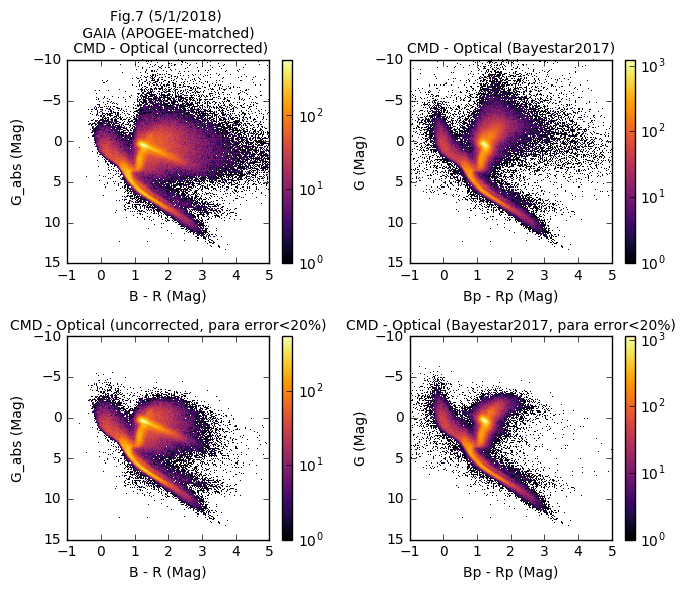

In [17]:
idx_optical = ( (Gabs!=-9999) & (Babs!=-9999) & (Gabs!=-9999) & (gaia('phot_g_mean_mag')<17)) # &idx_good_para
#idx_IR = ( (Jabs!=-9999) & (Habs!=-9999) & (Kabs!=-9999) & (Jabs!=Kabs))

f, ((ax1,ax2),(ax1b,ax2b))=subplots(2,2,figsize=(7,6))

cs1=ax1.hist2d( (Babs-Rabs)[idx_optical], Gabs[idx_optical], bins=200, range = ((-1,5),(-10, 15)),
          norm=mpl.colors.LogNorm(), cmap=mpl.cm.inferno)
ax1.set_xlabel('B - R (Mag)')
ax1.set_ylabel('G_abs (Mag)')
ax1.invert_yaxis()
ax1.set_title('Fig.7 (5/1/2018) \n GAIA (APOGEE-matched) \n CMD - Optical (uncorrected)',fontsize=10)
f.colorbar(cs1[3], ax=ax1)

cs1b=ax1b.hist2d( (Babs-Rabs)[idx_optical&idx_good_para], Gabs[idx_optical&idx_good_para], bins=200, range = ((-1,5),(-10, 15)),
          norm=mpl.colors.LogNorm(), cmap=mpl.cm.inferno)
ax1b.set_xlabel('B - R (Mag)')
ax1b.set_ylabel('G_abs (Mag)')
ax1b.invert_yaxis()
ax1b.set_title('CMD - Optical (uncorrected, para error<20%)',fontsize=10)
f.colorbar(cs1b[3], ax=ax1b)

cs2=ax2.hist2d( (Bcorr-Rcorr)[idx_optical], Gcorr[idx_optical], bins=200, range = ((-1,5),(-10, 15)),
          norm=mpl.colors.LogNorm(), cmap=mpl.cm.inferno)
ax2.set_xlabel('Bp - Rp (Mag)')
ax2.set_ylabel('G (Mag)')
ax2.invert_yaxis()
ax2.set_title('CMD - Optical (Bayestar2017)',fontsize=10)
f.colorbar(cs2[3], ax=ax2)

cs2b=ax2b.hist2d( (Bcorr-Rcorr)[idx_optical&idx_good_para], Gcorr[idx_optical&idx_good_para], bins=200, range = ((-1,5),(-10, 15)),
          norm=mpl.colors.LogNorm(), cmap=mpl.cm.inferno)
ax2b.set_xlabel('Bp - Rp (Mag)')
ax2b.set_ylabel('G (Mag)')
ax2b.invert_yaxis()
ax2b.set_title('CMD - Optical (Bayestar2017, para error<20%)',fontsize=10)
f.colorbar(cs2b[3], ax=ax2b)

plt.tight_layout()
show()

In [18]:
Image(url= "gaia_fig19.jpg",width=600)

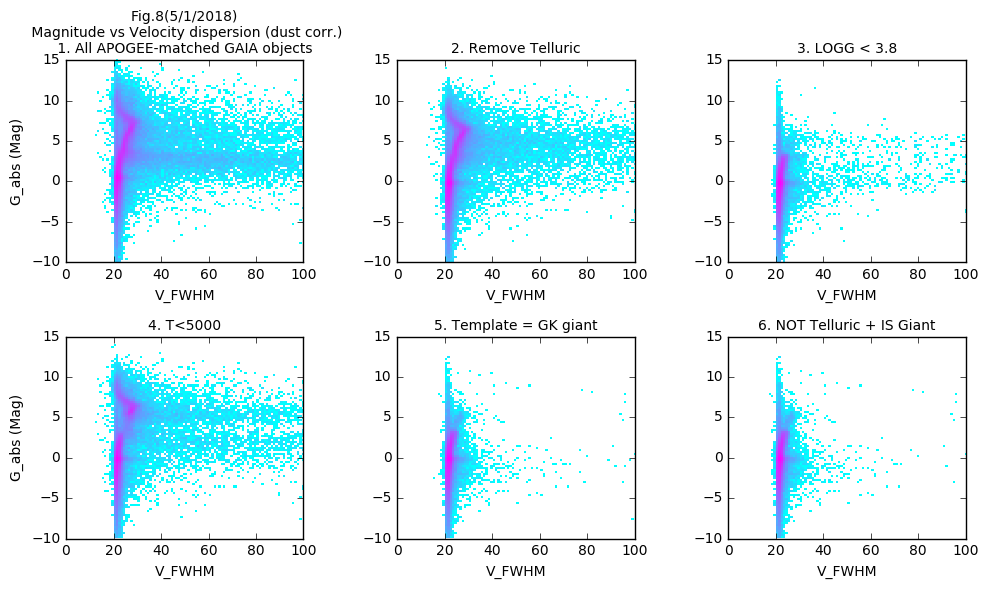

In [19]:
labels_arr = ['ALL','Remove Telluric', 'LOGG < 3.8', 'T<5000', 
              'Template = GK giant', 'NOT Telluric + IS Giant']

f, axes = subplots(2,3,figsize=(10,6))
axes=axes.flatten()

#colorbar(CB)
i=0
for icut in [1, cut_telluric, cut_logg, cut_teff, cut_class, cut_telluric*cut_class]:
    axes[i].set_title(str(i+1)+'. '+labels_arr[i], fontsize=10)
    axes[i].set_xlabel('V_FWHM')
    if i in [0,3]: axes[i].set_ylabel('G_abs (Mag)')
    if i==0:
        cs=axes[i].hist2d(RV, Gcorr, bins=100, range=((0,100),(-10, 15)),
                       norm=mpl.colors.LogNorm(), cmap=mpl.cm.cool)
    else:
        cs=axes[i].hist2d(RV[where(icut)], Rcorr[where(icut)], bins=100, range=((0,100),(-10, 15))
                      ,norm=mpl.colors.LogNorm(), cmap=mpl.cm.cool)
    #f.colorbar(cs[3], ax=axes[i])
    i+=1
axes[0].set_title('Fig.8(5/1/2018)\n Magnitude vs Velocity dispersion (dust corr.)\n 1. All APOGEE-matched GAIA objects ', 
                  fontsize=10)
plt.tight_layout()
show()

In [20]:
################################
### pick out perculiar objects 
### (1) separate MS and Giants
### (2) find stars that are more than 2.5 mag (10 stars) brighter than the mean magnitude
### (3) find stars with large vmacro, also check the 2 vmacros and RV_FWHM
### (4) check the goodness of the fit

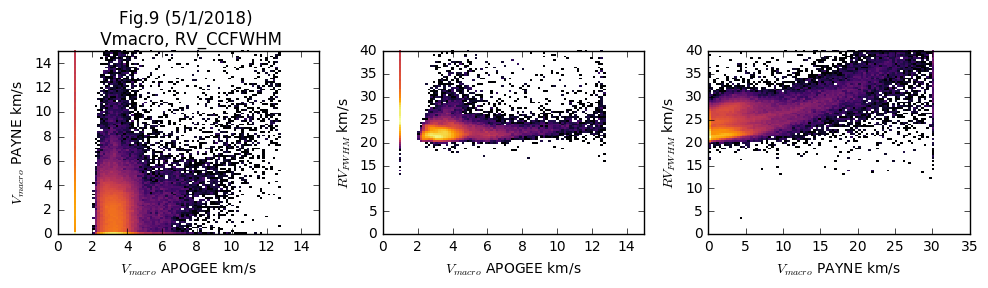

In [21]:
######### check 3 linewithd measurement
# RV = hdulist[1].data['RV_CCFWHM'][idx_apo]
# VmacP = vmac_payne[idx_payne]
# VmacA = hdulist[1].data['VMACRO'][idx_apo]
# VmicA= hdulist[1].data['VMICRO'][idx_apo]

f, (ax1,ax2,ax3)=subplots(1,3,figsize=(10,3))
ax1.hist2d(VmacA[~idx_badpayne], VmacP[~idx_badpayne], bins=100, range=((0,15), (0,15)),
           norm=mpl.colors.LogNorm(), cmap=mpl.cm.inferno)
ax1.set_xlabel('$V_{macro}$ APOGEE km/s')
ax1.set_ylabel('$V_{macro}$ PAYNE km/s')
ax1.set_title('Fig.9 (5/1/2018) \n Vmacro, RV_CCFWHM')

ax2.hist2d(VmacA[~idx_badpayne], RV[~idx_badpayne], bins=100, range=((0,15), (0,40)),
          norm=mpl.colors.LogNorm(), cmap=mpl.cm.inferno)
ax2.set_xlabel('$V_{macro}$ APOGEE km/s')
ax2.set_ylabel('$RV_{FWHM}$ km/s')
ax3.hist2d(VmacP[~idx_badpayne], RV[~idx_badpayne], bins=100, range=((0,35), (0,40)),
          norm=mpl.colors.LogNorm(), cmap=mpl.cm.inferno)
ax3.set_xlabel('$V_{macro}$ PAYNE km/s')
ax3.set_ylabel('$RV_{FWHM}$ km/s')

plt.tight_layout()
show()

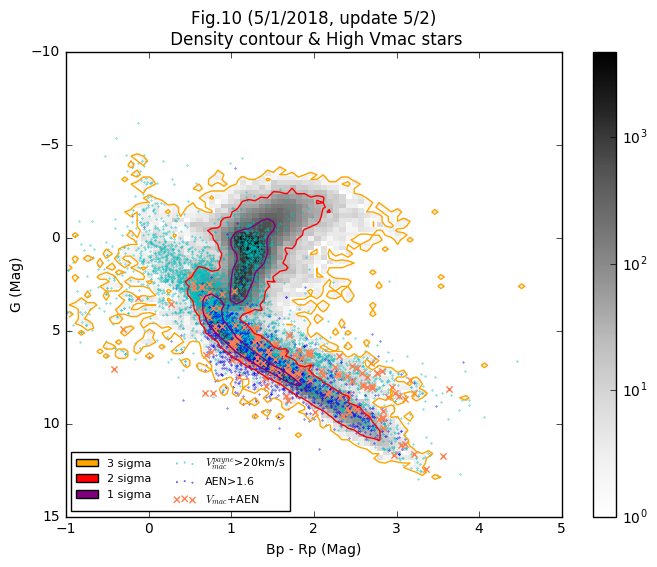

In [24]:
vmac_min=20
idx_cut = (idx_optical&idx_good_para&cut_telluric)
c0,c1=-1,5
m0,m1=-10, 15
bin0 = linspace(c0,c1,81)
bin1 = linspace(m0,m1,101)
b0c=WLanalysis.edge2center(bin0)
b1c=WLanalysis.edge2center(bin1)
ihist,bin0,bin1 = histogram2d((Bcorr-Rcorr)[idx_cut], Gcorr[idx_cut], bins=(bin0, bin1))
Y,X=meshgrid(b1c,b0c)
levels=sort(WLanalysis.findlevel(ihist))

cut_vmac = (idx_optical&idx_good_para&cut_telluric&(~idx_badpayne)&(VmacP>vmac_min))
cut_AEN  = (idx_optical&idx_good_para&cut_telluric&(~idx_badpayne)&(AEN>AEN_min))

f, ax =subplots(1,1,figsize=(8,6))
cb=ax.imshow(ihist.T, norm=mpl.colors.LogNorm(), cmap=mpl.cm.Greys, 
          interpolation='nearest',aspect='auto',extent=(c0,c1,m0,m1),origin='lower')
f.colorbar(cb, ax=ax)

p1=ax.scatter((Bcorr-Rcorr)[cut_vmac],Gcorr[cut_vmac],c='c', 
           edgecolors='face',s=0.1,label='Vmac_payne>%ikm/s'%(vmac_min))

# ax.scatter((Bcorr-Rcorr)[cut_vmac & (VmacP==amax(VmacP))],Gcorr[cut_vmac & (VmacP==amax(VmacP))],c='b', 
#            edgecolors='face',s=0.1)

p2=ax.scatter((Bcorr-Rcorr)[cut_AEN],Gcorr[cut_AEN],c='b', 
           edgecolors='face',s=0.1)
p3=ax.scatter((Bcorr-Rcorr)[cut_AEN&cut_vmac],Gcorr[cut_AEN&cut_vmac],c='coral',marker=u'x', 
           edgecolors='face')#,s=5)


ax.contour(X,Y,ihist, levels=levels,colors=('orange','red','purple'))
ax.set_xlim(c0,c1)
ax.set_ylim(m0,m1)
proxy=[plt.Rectangle((0,0),1,1,ec=None, fc=icolor) for icolor in ('orange','red','purple')]
proxy.append(p1)
proxy.append(p2)
proxy.append(p3)

ilabels=['3 sigma', '2 sigma', '1 sigma', '$V_{mac}^{payne}$>%ikm/s'%(vmac_min),'AEN>%.1f'%(AEN_min), '$V_{mac}$+AEN']
ax.legend(proxy, ilabels,loc=3,fontsize=8,ncol=2)
ax.invert_yaxis()
ax.set_xlabel('Bp - Rp (Mag)')
ax.set_ylabel('G (Mag)')
ax.set_title('Fig.10 (5/1/2018, update 5/2)\n Density contour & High Vmac stars')

show()

In [39]:
############# cut out the dimmer but outside 2 sigma objects
color_arr = linspace(-1,5,10)
Yx = lambda color: 3.5*color+1
level2=levels[1]
cells_pass = ones(ihist.shape)
cells_pass[ihist>level2] = 0
cells_pass[Yx(X)<Y] = 0
test_pass = NearestNDInterpolator(zip(X.flatten(), Y.flatten()), cells_pass.flatten())

color_corr = (Bcorr-Rcorr)
color_corr[isnan(color_corr)]=99
iGcorr = Gcorr.copy()
iGcorr[isnan(Gcorr)]=99
coords_pass = test_pass(zip(color_corr,  iGcorr)).astype(int)
################

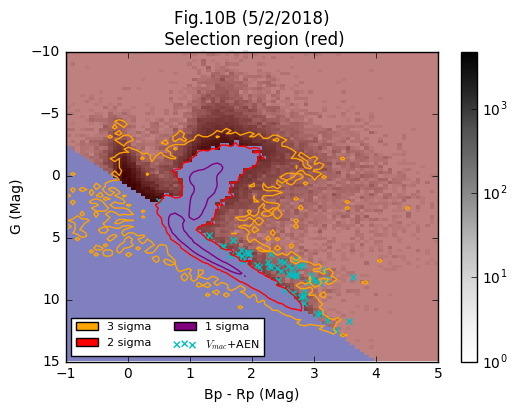

In [42]:
f, ax =subplots(1,1,figsize=(6,4))
# cb=ax.imshow(ihist.T, norm=mpl.colors.LogNorm(), cmap=mpl.cm.Greys, 
#           interpolation='nearest',aspect='auto',extent=(c0,c1,m0,m1),origin='lower')
f.colorbar(cb, ax=ax)
ax.hist2d((Bcorr-Rcorr)[coords_pass>0], Gcorr[coords_pass>0], bins=(bin0, bin1),
          norm=mpl.colors.LogNorm(), cmap=mpl.cm.Greys)
ax.contour(X,Y,ihist, levels=levels,colors=('orange','red','purple'))
ax.set_xlim(c0,c1)
ax.set_ylim(m0,m1)
proxy=[plt.Rectangle((0,0),1,1,ec=None, fc=icolor) for icolor in ('orange','red','purple')]

ilabels=['3 sigma', '2 sigma', '1 sigma',  '$V_{mac}$+AEN']
p3=ax.scatter((Bcorr-Rcorr)[cut_AEN&cut_vmac&(coords_pass>0)],
              Gcorr[cut_AEN&cut_vmac&(coords_pass>0)],c='c',marker=u'x',edgecolors='face')
proxy.append(p3)
ax.legend(proxy, ilabels,loc=3,fontsize=8,ncol=2)

ax.imshow(cells_pass.T, interpolation='nearest',aspect='auto',extent=(c0,c1,m0,m1),origin='lower',alpha=0.5)

ax.invert_yaxis()
ax.set_xlabel('Bp - Rp (Mag)')
ax.set_ylabel('G (Mag)')
ax.set_title('Fig.10B (5/2/2018)\n Selection region (red)')

show()

In [43]:
sum(coords_pass), sum(cut_AEN&cut_vmac&(coords_pass>0))
idx_selected = where(cut_AEN&cut_vmac&(coords_pass>0))[0]
id_selected = hdulist[1].data['APOGEE_ID'][idx_apo][idx_selected]
print len(unique(id_selected)), len(id_selected)
savetxt('APOGEE_ID_AEN_VMAC_MAG_cut.txt',id_selected, fmt='%s')

57 61


In [44]:
id_selected

chararray(['2M02530816+3657562', '2M03291667+3116182', '2M03424086+3213347',
       '2M03443918+3220089', '2M03443979+3218041', '2M03455498+2413262',
       '2M03470474+2522502', '2M03483480+2410523', '2M03490585+2344232',
       '2M03543361+2540437', '2M04063793-0641509', '2M05291961+0326001',
       '2M05310048+1131374', '2M05312693+1210204', '2M05323428+1227325',
       '2M05332240-0532335', '2M05334609-0534264', '2M05335414-0503401',
       '2M05342706-0532291', '2M05342706-0532291', '2M05345803-0612237',
       '2M05345803-0612237', '2M05350504-0432334', '2M05351002-0441169',
       '2M05351157-0446337', '2M05351767-0558265', '2M05351846-0524068',
       '2M05352255-0508007', '2M05352543-0521515', '2M05352716-0619420',
       '2M05353138-0558402', '2M05353994-0457312', '2M05360416-0504088',
       '2M05360492-0213204', '2M05362890-0514434', '2M05372393-0127238',
       '2M05380548-0653147', '2M05380548-0653147', '2M05385038-0226477',
       '2M05410463-0745403', '2M05410463-074540

/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in divide
/Users/jia/anaconda/lib/python2.7/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


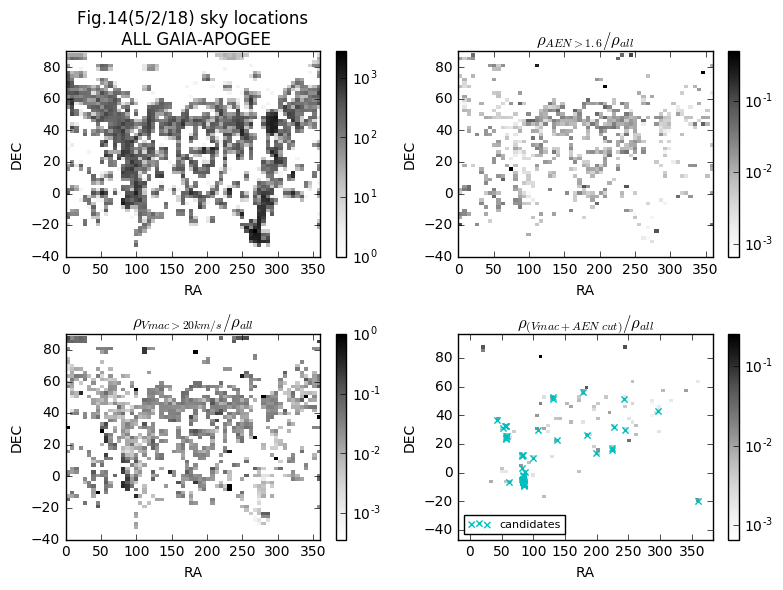

In [45]:
f, ((ax1,ax2),(ax3,ax4))=subplots(2,2,figsize=(8,6))

ihist0, bin1, bin2 = histogram2d(ra_gaia,dec_gaia, range=((0,360),(-40,90)),bins=60)
icb=ax1.imshow(ihist0.T, norm=mpl.colors.LogNorm(),cmap=mpl.cm.Greys,
           interpolation='nearest',origin='lower',extent=[0,360,-40,90],aspect='auto')
f.colorbar(icb,ax=ax1)
i=0
for icut in (cut_AEN, cut_vmac, cut_vmac&cut_AEN):
    ihist, bin1, bin2 = histogram2d(ra_gaia[icut], dec_gaia[icut], range=((0,360),(-40,90)),bins=60) 
    iax=[ax2,ax3,ax4][i]
    i+=1
    icb=iax.imshow(ihist.T/ihist0.T, norm=mpl.colors.LogNorm(),cmap=mpl.cm.Greys,interpolation='nearest'
              ,origin='lower',extent=[0,360,-40,90],aspect='auto')
    iax.set_ylabel('DEC')
    iax.set_xlabel('RA')
    f.colorbar(icb,ax=iax)
ax4.scatter(ra_gaia[idx_selected], dec_gaia[idx_selected],marker=u'x',color='c',label='candidates')
ax4.legend(frameon=1,fontsize=8,loc=3,)

ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')
ax1.set_title('Fig.14(5/2/18) sky locations\n ALL GAIA-APOGEE')
ax2.set_title(r'$\rho_{AEN>%.1f}/ \rho_{all}$'%(AEN_min))
ax3.set_title(r'$\rho_{Vmac>%ikm/s}/ \rho_{all}$'%(vmac_min))
ax4.set_title(r'$\rho_{(Vmac+AEN\; cut)}/ \rho_{all}$')

plt.tight_layout()
show()

In [46]:
sum(VmacA==1), sum(VmacP==-999)

(95953, 81)

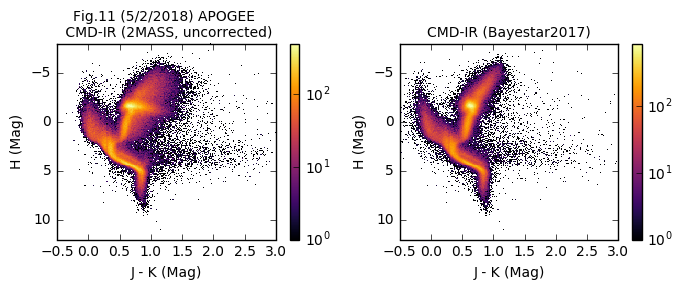

In [47]:
idx_IR = ((Jabs!=-9999) & (Habs!=-9999) & (Kabs!=-9999) & 
          (Jabs!=Kabs) & (Japo[idx_apo]!=99) & (Hapo[idx_apo]!=99) & (Hapo[idx_apo]!=99) & idx_good_para)

irange=((-0.5,3),(-8, 12))
f, (ax1,ax2)=subplots(1,2,figsize=(7,3))

cs1=ax1.hist2d( (Jabs-Kabs)[idx_IR], Habs[idx_IR], bins=200, range = irange,
          norm=mpl.colors.LogNorm(), cmap=mpl.cm.inferno)
ax1.set_xlabel('J - K (Mag)')
ax1.set_ylabel('H (Mag)')
ax1.invert_yaxis()
ax1.set_title('Fig.11 (5/2/2018) APOGEE \n CMD-IR (2MASS, uncorrected)',fontsize=10)
f.colorbar(cs1[3], ax=ax1)

cs2=ax2.hist2d( (Jcorr-Kcorr)[idx_IR], Hcorr[idx_IR], bins=200, range = irange,
          norm=mpl.colors.LogNorm(), cmap=mpl.cm.inferno)
ax2.set_xlabel('J - K (Mag)')
ax2.set_ylabel('H (Mag)')
ax2.invert_yaxis()
ax2.set_title('CMD-IR (Bayestar2017)',fontsize=10)
f.colorbar(cs2[3], ax=ax2)

plt.tight_layout()
show()

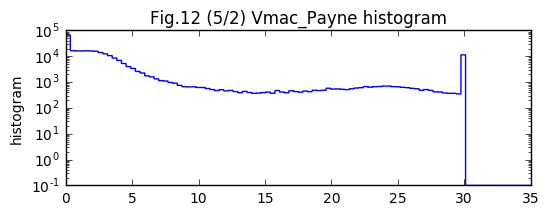

In [48]:
sum(VmacP==amax(VmacP))
f,ax=subplots(1,1,figsize=(6,2))
ax.hist(VmacP,bins=100,range=(0,35),log=1,histtype='step')
ax.set_ylabel('histogram')
ax.set_title('Fig.12 (5/2) Vmac_Payne histogram')
show()

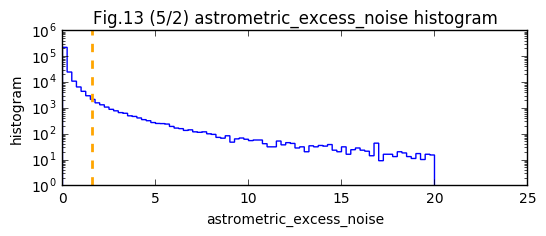

In [49]:
f,ax=subplots(1,1,figsize=(6,2))
ax.hist(AEN,bins=100,range=(0,25),log=1,histtype='step')
ax.plot((AEN_min, AEN_min), [1, 1e6],'--',color='orange',lw=2)
ax.set_xlabel('astrometric_excess_noise')
ax.set_ylabel('histogram')
ax.set_title('Fig.13 (5/2) astrometric_excess_noise histogram')
show()

In [50]:
### copied code from https://github.com/dkirkby/bossdata
from bits import *
### test the usage
decode_bitmask(APOGEE_TARGET1,3)

('APOGEE_FAINT', 'APOGEE_MEDIUM')

In [51]:
### check target
flags_apo = [APOGEE_TARGET1,APOGEE_TARGET2,
               APOGEE2_TARGET1,APOGEE2_TARGET2,APOGEE2_TARGET3]
flags_apo_txt = ['APOGEE_TARGET1','APOGEE_TARGET2',
               'APOGEE2_TARGET1','APOGEE2_TARGET2','APOGEE2_TARGET3']
flag_len = [len(iflag._reverse_map) for iflag in flags_apo]

def check_flags (idx):
    for i in range(len(flags_apo)):        
        iflag = hdulist[1].data[flags_apo_txt[i]][idx_apo][idx]
        #print flags_apo_txt[i], iflag
        if iflag!=0:
            for j in range(flag_len[i]):
                if not logical_not (iflag & 2**j):
                    print flags_apo_txt[i],flags_apo[i]._reverse_map[j]
for ii in idx_selected:
    print '\n',hdulist[1].data['APOGEE_ID'][idx_apo][ii]
    check_flags (ii)


2M02530816+3657562
APOGEE2_TARGET1 APOGEE2_TWOBIN_GT_0_8
APOGEE2_TARGET1 APOGEE2_SFD_DERED
APOGEE2_TARGET1 APOGEE2_SHORT
APOGEE2_TARGET1 APOGEE2_NORMAL_SAMPLE

2M03291667+3116182
APOGEE_TARGET1 APOGEE_ANCILLARY
APOGEE_TARGET1 APOGEE_CHECKED
APOGEE_TARGET2 APOGEE_EMBEDDEDCLUSTER_STAR

2M03424086+3213347
APOGEE_TARGET1 APOGEE_ANCILLARY
APOGEE_TARGET1 APOGEE_CHECKED
APOGEE_TARGET2 APOGEE_EMBEDDEDCLUSTER_STAR

2M03443918+3220089
APOGEE_TARGET1 APOGEE_ANCILLARY
APOGEE_TARGET1 APOGEE_CHECKED
APOGEE_TARGET2 APOGEE_EMBEDDEDCLUSTER_STAR

2M03443979+3218041
APOGEE_TARGET1 APOGEE_ANCILLARY
APOGEE_TARGET1 APOGEE_CHECKED
APOGEE_TARGET2 APOGEE_EMBEDDEDCLUSTER_STAR

2M03455498+2413262
APOGEE_TARGET2 APOGEE_CALIB_CLUSTER

2M03470474+2522502
APOGEE_TARGET2 APOGEE_CALIB_CLUSTER

2M03483480+2410523
APOGEE2_TARGET3 APOGEE2_YOUNG_CLUSTER

2M03490585+2344232
APOGEE2_TARGET3 APOGEE2_YOUNG_CLUSTER

2M03543361+2540437
APOGEE2_TARGET1 APOGEE2_APOKASC_GIANT

2M04063793-0641509
APOGEE2_TARGET1 APOGEE2_SFD_DERED
